# Comparing FF to PC Weights
Purpose:
- To investigate the relationship between weights generated by:
   1. FF + Backprop, with weight decay
   2. PC with weight decay
- I hypothesize that they will produce very similar weights (compared to not including weight decay for at least one of them).

In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
import NeuralNetwork as NN
import FFNetwork as FF
import Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(FF)
importlib.reload(Layer);

In [29]:
def ClassPlot(x, labels=[], idx=(1,2)):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    plt.axis('equal');

In [30]:
def cosine_proximity(M1, M2):
    return np.sum(M1*M2) / np.linalg.norm(M1.flatten()) / np.linalg.norm(M2.flatten())

## Create a simple dataset

In [31]:
# This creates a dataset

n_classes = 3
#hidden_dim = 5
sensory_dim = 5

seed = 2610
torch.manual_seed(seed)
np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[-0.48932516  0.13014042  1.4684664   0.48737025  0.72496988]
 [-1.2323579  -1.16497735  0.56182042 -1.46463011  0.16859907]
 [-1.22924953 -0.43436831  1.13980164 -1.40424674 -0.86098236]]


In [32]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2, seed=None):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    if seed!=None:
        np.random.seed(seed)
    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [33]:
train = MakeDataset(A, B, noise=0.2)

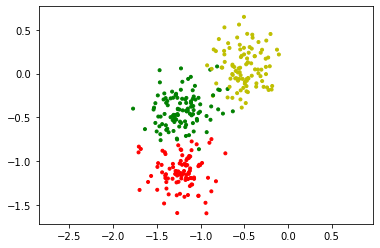

In [34]:
ClassPlot(train[1], labels=train[0], idx=(0,1))

# FF + Backprop

In [161]:
lr = 0.01   # learning rate
Wdecay = 0.0007  # weight decay
af = 'identity'
mid_af = 'logistic'
mult = 4.

In [162]:
# Create a network
ffnet = FF.Network()
ffnet.AddLayer(FF.Layer(n_nodes=sensory_dim, act=af))
#ffnet.AddLayer(FF.Layer(n_nodes=hidden_dim, act=mid_af))
ffnet.AddLayer(FF.Layer(n_nodes=n_classes, act=af))
ffnet.SetCostFunction('MSE')

In [171]:
# Train a bunch, and record the weight matrices
# One trial's matrix in each col
n_trials = 10
Wff_decay = []
total_accuracy = 0.
for trial in range(n_trials):
    ffnet.RandomWeights(mult=mult)
    ffnet.SGD(train[1].numpy(), train[0].numpy(), lrate=lr, epochs=500, batch_size=30, decay=0.000, progress=1000)
    total_accuracy += FF.ClassificationAccuracy(ffnet.FeedForward(train[1].numpy()), train[0].numpy())
    Wff_decay.append(ffnet.W[0].flatten())
Wff_decay = np.array(Wff_decay).T
print('Accuracy = '+str(np.round(total_accuracy/n_trials*100, 2))+'%')

Accuracy = 99.87%


# PC

In [167]:
pcnet = NN.NeuralNetwork()
pcnet.AddLayer(Layer.InputPELayer(n=n_classes))
pcnet.AddLayer(Layer.TopPELayer(n=sensory_dim))
pcnet.Connect(0,1, act='identity', symmetric=True)
pcnet.SetTau(0.02)
pcnet.learning_tau = 0.08
pcnet.learning_biases = False
pcnet.SetWeightDecay(0.0)

identity


In [168]:
pcnet.connections[0].RandomWeights(mult=4.)
print(pcnet.connections[0].M.numpy().flatten())
print(pcnet.connections[0].W.numpy().flatten())

[-1.0679038  -5.5174794   0.12808277  1.8289311   1.7101889   2.8408432
  0.6417762  -0.36161733 -0.34190246  1.0379795   0.5758395  -3.7995887
 -1.80463    -0.7752209  -1.0111195 ]
[-1.0679038   1.8289311   0.6417762   1.0379795  -1.80463    -5.5174794
  1.7101889  -0.36161733  0.5758395  -0.7752209   0.12808277  2.8408432
 -0.34190246 -3.7995887  -1.0111195 ]


In [169]:
pcnet.Learn(train[0], train[1], T=5., dt=0.001, epochs=1, batch_size=30, turn_down_lam=1.)

FloatProgress(value=0.0, max=300.0)

In [170]:
print(pcnet.connections[0].M.numpy().flatten())
print(pcnet.connections[0].W.numpy().flatten())
print(Wpc_decay)

[-0.01806084  0.01249809  0.00383301  0.20622781 -0.30410647  0.09657754
  0.04351087 -0.39359993  0.3527585   0.30160934 -0.25389758 -0.0479055
  0.20093687  0.4308295  -0.6312304 ]
[-0.01806084  0.20622781  0.04351087  0.30160934  0.20093687  0.01249809
 -0.30410647 -0.39359993 -0.25389758  0.4308295   0.00383301  0.09657754
  0.3527585  -0.0479055  -0.6312304 ]
[[ 0.08440321  0.1047947   0.13187994  0.13380432  0.12622583  0.0701439
   0.06506601  0.08431065  0.10914839  0.14510924]
 [-0.00326261  0.12102818 -0.07386307 -0.00236116 -0.16634211 -0.03650205
  -0.08801453 -0.02542974 -0.10665977 -0.09106015]
 [-0.08114225 -0.22582172 -0.05801283 -0.13143787  0.0401133  -0.03363868
   0.02294938 -0.05887926 -0.00248971 -0.0540486 ]
 [ 0.16887376  0.09823778  0.16203532  0.19537884  0.1598802   0.15731432
   0.16463056  0.11502118  0.16274732  0.17243332]
 [-0.32485142 -0.35069397 -0.39906257 -0.31311023 -0.40713468 -0.48137197
  -0.45129597 -0.3956714  -0.3639921  -0.29024905]
 [ 0.1559

In [165]:
# Train a bunch, and record the weight matrices
# One trial's matrix in each col
n_trials = 10
Wpc_decay = []
total_accuracy = 0.
for trial in range(n_trials):
    pcnet.connections[0].RandomWeights(mult=mult)
    pcnet.Learn(train[0], train[1], T=5., dt=0.001, epochs=5, batch_size=50, turn_down_lam=1.)
    Wpc_decay.append(pcnet.connections[0].M.numpy().flatten())
    print(pcnet.connections[0].M.numpy().flatten())
Wpc_decay = np.array(Wpc_decay).T

FloatProgress(value=0.0, max=1500.0)

[ 0.08440321 -0.00326261 -0.08114225  0.16887376 -0.32485142  0.15597712
  0.10063533 -0.4270616   0.3264296   0.29667088 -0.20905963 -0.08761223
  0.14585057  0.39163297 -0.53748214]


FloatProgress(value=0.0, max=1500.0)

[ 0.1047947   0.12102818 -0.22582172  0.09823778 -0.35069397  0.25245622
  0.12987265 -0.34492695  0.2150519   0.31559294 -0.25393063 -0.06166143
  0.12010197  0.4011516  -0.5212544 ]


FloatProgress(value=0.0, max=1500.0)

[ 0.13187994 -0.07386307 -0.05801283  0.16203532 -0.39906257  0.23702843
  0.14159761 -0.43047285  0.28886998  0.26938498 -0.14749834 -0.12188593
  0.15059374  0.41020453 -0.5608006 ]


FloatProgress(value=0.0, max=1500.0)

[ 0.13380432 -0.00236116 -0.13143787  0.19537884 -0.31311023  0.11773251
  0.08846731 -0.3540847   0.2656097   0.24513628 -0.23435155 -0.01078357
  0.16842951  0.43148118 -0.59991276]


FloatProgress(value=0.0, max=1500.0)

[ 0.12622583 -0.16634211  0.0401133   0.1598802  -0.40713468  0.24725401
  0.08993138 -0.46913776  0.37921166  0.28918836 -0.08580427 -0.20338574
  0.15620904  0.35702354 -0.51323074]


FloatProgress(value=0.0, max=1500.0)

[ 0.0701439  -0.03650205 -0.03363868  0.15731432 -0.48137197  0.32405725
  0.11939028 -0.36155754  0.24216335  0.3051381  -0.15009694 -0.15503941
  0.17302856  0.35650846 -0.52953947]


FloatProgress(value=0.0, max=1500.0)

[ 0.06506601 -0.08801453  0.02294938  0.16463056 -0.45129597  0.2866659
  0.08225229 -0.40565965  0.32340583  0.30419606 -0.11760009 -0.18659607
  0.15113775  0.34624225 -0.4973799 ]


FloatProgress(value=0.0, max=1500.0)

[ 0.08431065 -0.02542974 -0.05887926  0.11502118 -0.3956714   0.2806506
  0.05745967 -0.28189957  0.22443666  0.32149392 -0.17505486 -0.14643832
  0.14226927  0.40775195 -0.5500224 ]


FloatProgress(value=0.0, max=1500.0)

[ 0.10914839 -0.10665977 -0.00248971  0.16274732 -0.3639921   0.20124492
  0.07832851 -0.3593474   0.28101942  0.29357988 -0.21254757 -0.08103286
  0.15319292  0.48366696 -0.6368591 ]


FloatProgress(value=0.0, max=1500.0)

[ 0.14510924 -0.09106015 -0.0540486   0.17243332 -0.29024905  0.11781619
  0.10698144 -0.35326982  0.24628806  0.24397746 -0.1790634  -0.06491429
  0.14871097  0.4157538  -0.5644646 ]


## Let's look at how similar the weight matrices are.

In [173]:
pcnet.connections[0].W_decay

0.0

In [97]:
cosine_proximity(Wff_decay[:,0], Wff_decay[:,1])

0.9999826180347006

In [103]:
cosine_proximity(Wpc_decay[:,0], Wpc_decay[:,1])

0.96486515

In [99]:
cosine_proximity(Wpc_decay[:,1], Wff_decay[:,0])

0.8936144993067157

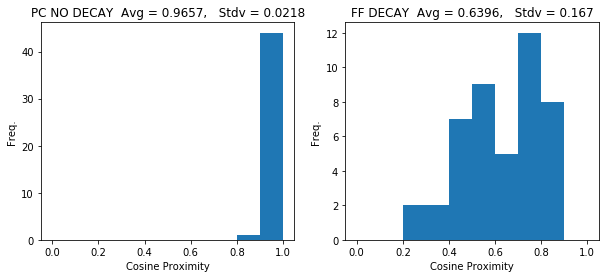

In [172]:
# Statistics of Cosine Proximity
titles = ['PC NO DECAY', 'FF DECAY']
plt.figure(figsize=(10,4))
for k,blah in enumerate([Wpc_decay, Wff_decay]):
    cp = []
    WsT = blah.T
    for i,w1 in enumerate(WsT):
        for j,w2 in enumerate(WsT[i+1:]):
            cp.append(cosine_proximity(w1,w2))
    cp = np.array(cp)

    plt.subplot(1,2,k+1)
    plt.hist(cp, range=[0,1]);
    plt.xlabel('Cosine Proximity'); plt.ylabel('Freq.');
    plt.title(titles[k]+'  Avg = '+str(np.round(np.mean(cp),4))+',   Stdv = '+str(np.round(np.std(cp),4)))
